---
### TITLE: The Inference with Sensors
### AUTHOR: Honggeun Ji
### DATE: 10.Nov.2021.
---

# Tap Position Inference with Flutter and Keras
<div>
<img src="https://media.vlpt.us/images/swara/post/f984346a-d7a6-4ff7-981e-9b71de5d61c7/flutter.png" width="200"/>
<img src="https://miro.medium.com/max/600/0*LZQf7b4u8f97izwV.png" width="200"/>
</div>

In this lab, I would like to show you the tap position inference using
these two sensory data.

*   Accelerometer Sensory Data
*   Gyroscope Sensory Data



# Data Collection



> **Q. What kinds of Sensory Data and How do we collect?**


### What Data?
**Inspired by Professor Li's "Privacy Leakage in Smart Device" introduction.**

*   In general, there are three diffent types of sensors on mobile devices.

         1. Accelerometer 
         2. Gyroscope
         3. Magnetometer

*   This lab only deals with those two sensors except the Magnetometer.

*   Based on those two sensors, we may collect sensory data at the moment our user tapped a zone.
*   The zones are divided into 12 parts; however, this lab will only show you the case of 6 tapping zone. (As I want to show you the testing case first, after this labs seems valid, I'll move on to the next stages.)

</br>

### Data, Data, Data... How to collect?
**Inspired from Android App Development introduction.**


*   The way how I develop an app is quite different from lagacy project.
*   Typically, professional developers choose the native development way so that the app works powerfully. (High performance, Faster Reload, and using the native hardware)

*   However, it requires at least 3 months to become confident on the native application development.
*   This is the reason why I choose **Flutter**. The Flutter is a cross-platform development framework made by Google.
*   Not that powerful than the native one, but **this still leads us to implement the sensor data.**
*   Also, the Flutter use the programming language, **Dart**, which is quite similar with Java.
*   Use the Flutter packages to capture the sensor data with tap position at the moment when a user tap those zone. 

</br>

**Tapping the App looks like,**
<div>
<img src="https://drive.google.com/uc?id=1F-Od3yLodwsoKUzGqZ9Cww9kqAWPvP3w" width="350" height="500">
<img src="https://drive.google.com/uc?id=1jyhw4BWNRr8NckquDIZMLWWQ4v2A4QEf" width="250" height="500">
</div>

</br>
</br>
</br>


> **Q. How do we collect?**

### Database Comes Here!

*   Send those sensory data and tap position information to the Database.
*   Here, I used FireStore from Google Firebase.

</br>

### What is Firestore?


*   It is a Database based on NoSQL.
*   Lightweight, Easy to store the data.
*   Easy to export the data into .csv or .json form.
*   Every record is regard as "Document".

*   Firestore looks like this,
<img src="https://drive.google.com/uc?id=1E4iyC5fTlCAWO_cJt6oOcoR7IQna_hvc" width="950" height="480">

*   My Flutter App will send those data set into this Firestore Database.
</br>
</br>
</br>


In [1]:
import pandas as pd
from sklearn import preprocessing

data_all = pd.read_csv('./sample_data/sensor_data.csv')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# x = data_all.drop(['__id__', 'tapped_zone', 'tap_position_x', 'tap_position_y'], axis=1)  # Drop evertyig except sensory data
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
features_to_normalize = ['accelerometer1', 'accelerometer2', 'accelerometer3', 'gyroscope1', 'gyroscope2', 'gyroscope3', 'pitch', 'roll']
x = scaler.fit_transform(data_all[features_to_normalize])
x = pd.DataFrame(x, columns = features_to_normalize)
# x = data_all.drop(['__id__', 'tappedZone', 'tapPositionX', 'tapPositionY'], axis=1)  # Drop evertyig except sensory data
y = data_all.tapped_zone  # only the tapping zone
# y = data_all.tappedZone  # only the tapping zone

In [ ]:
data_all.sample(5)

In [ ]:
x.sample(6)  # INPUT DATA

In [ ]:
y.sample(6)  # TARGET DATA

In [ ]:
print(x.shape)
print(y.shape)

In [3]:
x = x.dropna()
y = y.dropna()

In [ ]:
print(x.shape)
print(y.shape)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
import tensorflow as tf
y_train_encoded = tf.keras.utils.to_categorical(y_train)  # one-hot encoding for training target
y_val_encoded = tf.keras.utils.to_categorical(y_val)      # one-hot encoding for validate target

In [ ]:
# check out the shape
print(y_train_encoded.shape, y_val_encoded.shape)
print(x_train.shape, x_val.shape)

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()  # Entire Sequential Neural Network
model.add(Dense(16, activation='relu', input_shape=(8,), kernel_regularizer='l1')) # Add the hidden layer with 80 unit(Neuron)  
model.add(Dense(16, activation='relu', input_shape=(16, ), kernel_regularizer='l1'))
model.add(Dense(16, activation='relu', input_shape=(16, ), kernel_regularizer='l2'))
model.add(Dense(12, activation='softmax', input_shape=(16, )))  # Add the output layer (give us 12 classes)

# optimizer is SGD (Stochastic Gradient Descent) with Learning Rate = 0.01 (default)
# loss function should be categorical as this is the multiple classification problem
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_encoded, epochs=200, validation_data=(x_val, y_val_encoded))  # with 200 epochs

In [8]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.9752066135406494


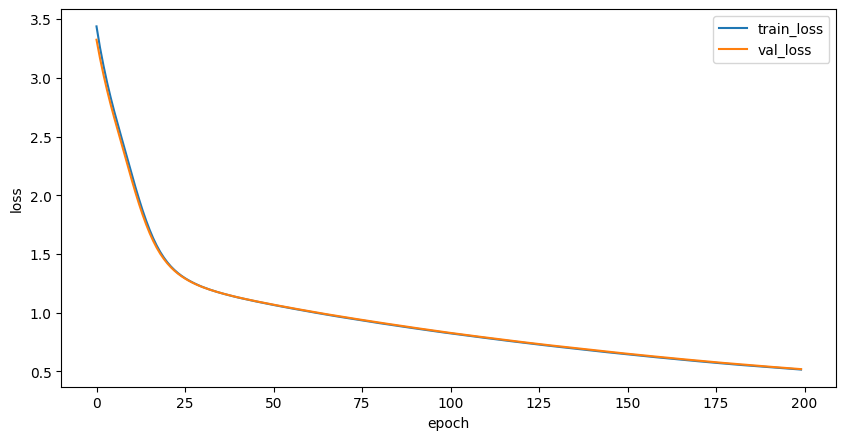

In [9]:
# loss graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

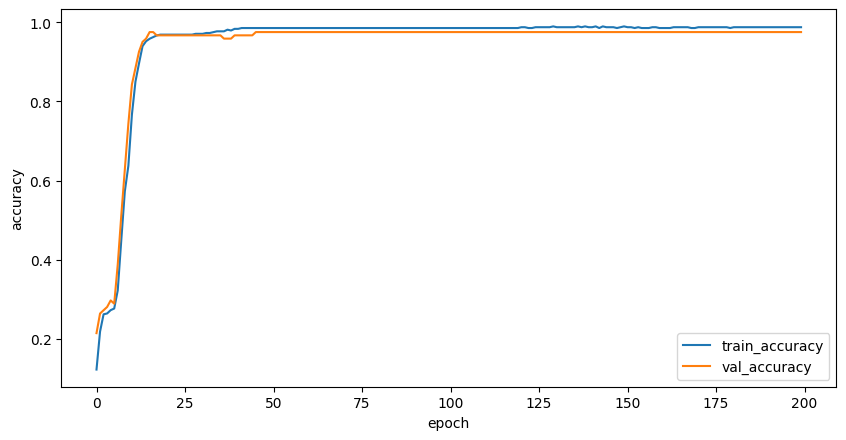

In [10]:
# accuracy graph
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [11]:
#import the testing .csv file
test_data_all = pd.read_csv('sample_data/sensor_data_test.csv')

# test data preprocessing
# x_test = test_data_all.drop(['__id__', 'tapped_zone', 'tap_position_x', 'tap_position_y'], axis=1)  # Drop evertyig except sensory data
y_test = test_data_all.tapped_zone  # only the tapping zone

# normalization
x_test = scaler.fit_transform(test_data_all[features_to_normalize])
x_test = pd.DataFrame(x_test, columns = features_to_normalize)

# drop the wrong record
x_test = x_test.dropna()
y_test = y_test.dropna()

# one-hot encoding for test target
y_test_encoded = tf.keras.utils.to_categorical(y_test)  

x_test.head()

,accelerometer1,accelerometer2,accelerometer3,gyroscope1,gyroscope2,gyroscope3,pitch,roll
0,-1.44069,-0.91736,-0.13765,1.40273,-1.33214,-0.42705,-0.89796,-1.54455
1,0.19317,0.63330,-0.60339,-0.53080,0.32305,-1.47860,0.76728,0.11053
2,-0.57066,0.19121,-0.04607,-0.97563,-0.61339,0.49138,0.24830,-0.66046
3,1.04363,-1.02163,-0.60983,0.60556,1.37136,1.02742,-1.18910,1.10871
4,0.96656,-0.33246,0.13626,0.75385,1.33442,1.00976,-0.25455,0.85463


In [12]:
loss2, accuracy2 = model.evaluate(x_test, y_test_encoded, verbose=0)
print(accuracy2)

0.9166666865348816


In [14]:
x_test[:5]

,accelerometer1,accelerometer2,accelerometer3,gyroscope1,gyroscope2,gyroscope3,pitch,roll
0,-1.44069,-0.91736,-0.13765,1.40273,-1.33214,-0.42705,-0.89796,-1.54455
1,0.19317,0.63330,-0.60339,-0.53080,0.32305,-1.47860,0.76728,0.11053
2,-0.57066,0.19121,-0.04607,-0.97563,-0.61339,0.49138,0.24830,-0.66046
3,1.04363,-1.02163,-0.60983,0.60556,1.37136,1.02742,-1.18910,1.10871
4,0.96656,-0.33246,0.13626,0.75385,1.33442,1.00976,-0.25455,0.85463


In [15]:
y_test[:5]

0    2.00000
1    9.00000
2   11.00000
3    0.00000
4    0.00000
Name: tapped_zone, dtype: float64

In [13]:
y_prob = model.predict(x_test[4:5])
y_classes = y_prob.argmax(axis=1)
print(y_classes)

[0]
